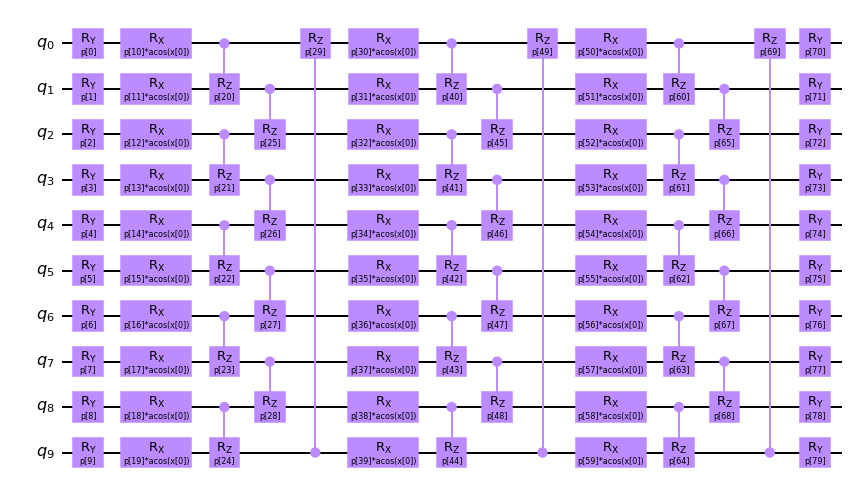

In [1]:
import numpy as np
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector, ParameterExpression
from qiskit.primitives import Estimator, Sampler, BackendEstimator, BackendSampler
from qiskit.quantum_info import SparsePauliOp
from qiskit import transpile
from qiskit import Aer


from squlearn.feature_map import ChebPQC
from squlearn.expectation_operator import SinglePauli, SummedPaulis
from squlearn.qnn.qnn import QNN
from squlearn.util import Executor,OpTree

from squlearn.util.optree import OpTreeList,OpTreeCircuit

import copy

# from circuit_tree import *

num_qubits = 10

pqc = ChebPQC(num_qubits, 1, 3)

x = ParameterVector("x", pqc.num_features)
p = ParameterVector("p", pqc.num_parameters)

QC = pqc.get_circuit(x, p)


# SUPPORTED_GATES = {
#     "x",
#     "y",
#     "z",
#     "h",
#     "rx",
#     "ry",
#     "rz",
#     "p",
#     "u",
#     "cx",
#     "cy",
#     "cz",
# }  # rzz,ryy,rxx also work!
# QC = transpile(QC, basis_gates=SUPPORTED_GATES)
QC.draw()

In [2]:
# QC = transpile_to_supported_instructions(QC)

In [3]:
d = OpTree.derivative.differentiate(QC, p)

In [4]:
grad = OpTree.simplify(d)
# grad = d

In [5]:
xval = [-0.5]
np.random.seed(0)
pval = np.random.rand(pqc.num_parameters)
dictionary = dict(zip(p, pval))
dictionary.update(dict(zip(x, xval)))

In [6]:
from pympler import asizeof

circ = OpTree.get_first_leaf(grad)
full_size = asizeof.asizeof(circ)
print(f"Size of circuit: {full_size} bytes")

Size of circuit: 399344 bytes


In [7]:
op = SummedPaulis(num_qubits, "X")
pop = ParameterVector("p", op.num_parameters)
op_dict = dict(zip(pop, np.random.rand(op.num_parameters)))
pauli_op = op.get_pauli(pop)
pauli_op = OpTreeList([pauli_op, pauli_op])

In [8]:
op2 = SummedPaulis(num_qubits, "Y")
pop2 = ParameterVector("p", op.num_parameters)
op_dict2 = dict(zip(pop2, np.random.rand(op.num_parameters)))
pauli_op2 = op.get_pauli(pop2)
print(pauli_op2)

SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4]), ParameterExpression(1.0*p[5]),
 ParameterExpression(1.0*p[6]), ParameterExpression(1.0*p[7]),
 ParameterExpression(1.0*p[8]), ParameterExpression(1.0*p[9]),
 ParameterExpression(1.0*p[10])])


In [9]:
print(op)

SparsePauliOp(['IIIIIIIIII', 'IIIIIIIIIX', 'IIIIIIIIXI', 'IIIIIIIXII', 'IIIIIIXIII', 'IIIIIXIIII', 'IIIIXIIIII', 'IIIXIIIIII', 'IIXIIIIIII', 'IXIIIIIIII', 'XIIIIIIIII'],
              coeffs=[ParameterExpression(1.0*p[0]), ParameterExpression(1.0*p[1]),
 ParameterExpression(1.0*p[2]), ParameterExpression(1.0*p[3]),
 ParameterExpression(1.0*p[4]), ParameterExpression(1.0*p[5]),
 ParameterExpression(1.0*p[6]), ParameterExpression(1.0*p[7]),
 ParameterExpression(1.0*p[8]), ParameterExpression(1.0*p[9]),
 ParameterExpression(1.0*p[10])])


In [10]:
OpTree.evaluate.evaluate_with_estimator(
    grad, pauli_op, dictionary, op_dict, Estimator(), detect_circuit_duplicates=False
)

TypeError: OpTreeEvaluate.evaluate_with_estimator() got an unexpected keyword argument 'detect_circuit_duplicates'

In [ ]:
total_dic = dictionary
total_dic.update(op_dict)

In [ ]:
expec_tree = OpTree.gen_expectation_tree(grad, pauli_op)

In [ ]:
total_dic2 = total_dic.copy()
total_dic2[pop[0]] = -1
total_dic2[pop[1]] = 2
total_dic2[x[0]] = -0.2
OpTree.evaluate.evaluate_expectation_tree_from_estimator(expec_tree, total_dic2, Estimator())

In [ ]:
OpTree.evaluate.evaluate_expectation_tree_from_estimator(expec_tree, [total_dic, total_dic2], Estimator())

In [ ]:
expec_tree = OpTree.gen_expectation_tree(grad, pauli_op)

In [ ]:
expec_tree = OpTree.evaluate.transform_tree_to_zbasis(expec_tree)

In [ ]:
OpTree.evaluate.evaluate_tree_with_sampler(expec_tree, [total_dic, total_dic2], Sampler())

In [ ]:
OpTree.evaluate.evaluate_tree_with_sampler(expec_tree, total_dic, Sampler())

In [ ]:
expec_tree2 = OpTree.gen_expectation_tree(grad, OpTreeList([pauli_op, pauli_op2]))

In [ ]:
total_dic2 = dictionary
total_dic2.update(op_dict2)

In [ ]:
OpTree.evaluate.evaluate_tree_with_estimator(expec_tree2, total_dic2, Estimator())

In [ ]:
expec_tree2 = OpTree.evaluate.transform_tree_to_zbasis(expec_tree2)

In [ ]:
dictionary2 = op_dict.copy()
dictionary2.update(op_dict2)
op_zbase = OpTree.evaluate.transform_tree_to_zbasis(OpTreeList([pauli_op, pauli_op2]))

In [ ]:
OpTree.evaluate.evaluate_tree_with_sampler(expec_tree2, [total_dic2, total_dic2], Sampler())

In [ ]:
OpTree.evaluate.evaluate_tree_with_sampler(
    expec_tree2, [total_dic2, total_dic2], Sampler(), detect_expectation_duplicates=True
)